# Facilities KPI by The Month
This notebook serves the Facilities Management Division (FMD) by supplying a number of helpful visualizations of divisional KPIs at the monthly level. These KPIs are traditionally shown only at the fiscal year level, so the charts gathered here allow FMD to drill down into a finer level of detail and investigate potential seasonality in the creation and completion of work orders.

Note that this notebook can be run only from within the City network due to its reliance on a direct SQL connection to the database DGS_Archibus.

## Setup

In [1]:
# workhorse modules
import pandas as pd
from datetime import timedelta, datetime
import re
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# local utility functions
from utils.general_utils import (
    add_fiscal_year,
    compute_is_on_time,
    duration_in_days,
    set_pd_params,
    tidy_up_df,
    trim_small_groups,
    cast_dtypes,
    compute_pm_cm_by_month,
    compute_kpi_table_by_month,
)
from utils.sql_utils import mssql_engine, get_data_from_archibus
from utils.vis_utils import set_plot_params, pointplot_with_barplot
from utils.anonymization import split_names, replace_names

Set a few global parameters.

In [2]:
set_pd_params()
set_plot_params(12, 6)
pd.options.mode.chained_assignment = None  # default='warn'

Obtain the data via a live SQL connection.

In [3]:
kpis_raw = get_data_from_archibus(mssql_engine(), "dash_benchmarks")
print(f"The work orders dataframe has {kpis_raw.shape[0]:,} rows.")

The work orders dataframe has 108,371 rows.


## Prepare the data
Because we're drawing from the already-cleaned view called `dash_benchmarks`, we don't drop any rows at this phase. If we instead drew from `wrhwr`, we'd see a few rows dropped here because their problem type is "TEST (DO NOT USE)". 

In [4]:
# make sure each column is of the correct data type
wr_tidy = cast_dtypes(kpis_raw)
# basic cleaning
wr_tidy = tidy_up_df(wr_tidy)

print(f"The tidied work orders dataframe has {len(wr_tidy):,} rows.")
print(f"By tidying the data, we have removed {len(kpis_raw) - len(wr_tidy):,} rows.")

The tidied work orders dataframe has 108,371 rows.
By tidying the data, we have removed 0 rows.


### Drop canceled and rejected work orders

In [5]:
# drop rows that were canceled
cond_valid = ~wr_tidy["status"].isin(["Can", "Rej", "R"])

wr_valid = wr_tidy[cond_valid]

print(
    f"By dropping canceled and rejected work orders, we have removed {len(wr_tidy) - len(wr_valid):,} rows."
)

By dropping canceled and rejected work orders, we have removed 4,042 rows.


### Assign fiscal year based on date of completion

In [6]:
# add 'fiscal_year' column based on date_closed
wr_fy = add_fiscal_year(wr_tidy, assign_fy_on="completion")

wr_fy[
    ["primary_type", "date_requested", "date_completed", "date_closed", "fiscal_year"]
].sample(3, random_state=446)

,primary_type,date_requested,date_completed,date_closed,fiscal_year
65300,PLUMBING,2017-04-25,2017-05-08,2020-01-27 11:31:17.087,2017
52740,SERVICE,2016-07-21,2016-07-21,2016-08-03 17:35:52.333,2017
775,ENVIRONMENTAL,2017-02-08,NaT,NaT,<NA>


### Limit data to current fiscal year

In [7]:
cond_current = wr_fy["fiscal_year"] == 2021
wr_current = wr_fy[cond_current]

print(
    f"By filtering to the current fiscal year, we have reduced to the data from {len(wr_fy):,} rows to {len(wr_current):,} rows."
)

By filtering to the current fiscal year, we have reduced to the data from 108,371 rows to 6,983 rows.


### Drop rows with no valid timeliness
A row with no data for `date_completed` or `benchmark` cannot be assessed as on time or not. So we drop these here. (Most of these belong to small problem types for which no benchmark has been assigned).

In [8]:
wr_main = wr_current.dropna(subset=["date_completed", "benchmark"])

print(
    f"Filtering to remove jobs with no data for `date_completed` or `benchmark` drops {len(wr_current) - len(wr_main):,} rows.",
    f"\nWe dropped {100 * round((len(wr_current) - len(wr_main))/len(wr_current), 2):}% of the data at this stage.",
)

Filtering to remove jobs with no data for `date_completed` or `benchmark` drops 80 rows. 
We dropped 1.0% of the data at this stage.


In [9]:
# add "is_on_time" column with performance data
wr_main["is_on_time"] = compute_is_on_time(
    wr_main["days_to_completion"], wr_main["benchmark"]
)
wr_main[["wr_id", "days_to_completion", "benchmark", "is_on_time"]].sample(3)

,wr_id,days_to_completion,benchmark,is_on_time
107947,144856,9.0,21.0,True
103203,134067,31.0,30.0,False
105157,137928,6.0,21.0,True


## Analysis
### Percentage of Preventive Maintanence Jobs Completed on Time

In [10]:
wr_pm = wr_main.copy()

# this defines which problem types are considered PMs
pm_list = [
    "PREVENTIVE_GENERAL",
    "PREVENTIVE_HVAC",
]

# filter data to PM types only
cond_pm = wr_pm["primary_type"].isin(pm_list)

# apply filter conditions
wr_pm = wr_pm[cond_pm]

print(f"The filtered PMs dataframe has {wr_pm.shape[0]:,} rows.")

The filtered PMs dataframe has 1,058 rows.


In [11]:
pm_compliance = compute_kpi_table_by_month(
    df=wr_pm,
    label_for_KPI="percent_PMs_on_time",
    label_for_totals="total_PMs",
    end_date="06-01-2021",
    grouping="date_completed",
)
pm_compliance

,percent_PMs_on_time,total_PMs,year_month
date_completed,,,
2020-07-31,49.25,67,Jul-20
2020-08-31,37.93,29,Aug-20
2020-09-30,53.85,39,Sep-20
2020-10-31,89.19,37,Oct-20
2020-11-30,4.98,281,Nov-20
2020-12-31,63.16,38,Dec-20
2021-01-31,26.32,38,Jan-21
2021-02-28,29.03,62,Feb-21
2021-03-31,19.59,97,Mar-21


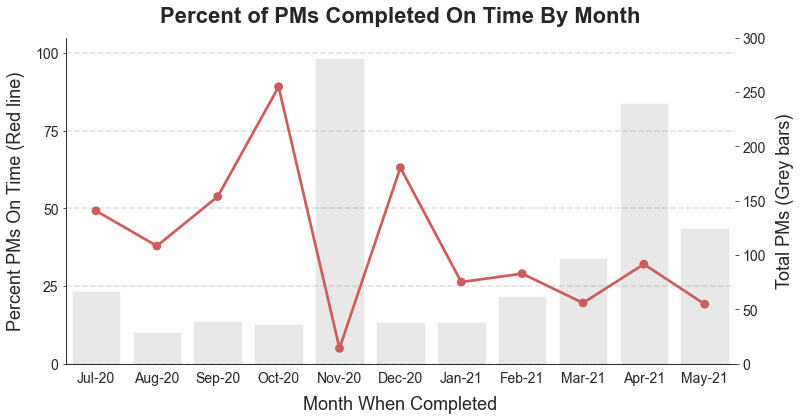

In [12]:
pointplot_with_barplot(
    pm_compliance,
    x=pm_compliance.year_month,
    point_y="percent_PMs_on_time",
    bar_y="total_PMs",
    yaxis_freq_bar=50,
    yaxis_freq_point=25,
    ymax_bar=300,
    xlabel="Month When Completed",
    ylabel_point="Percent PMs On Time (Red line)",
    ylabel_bar="Total PMs (Grey bars)",
    title="Percent of PMs Completed On Time By Month",
)

### Percentage of Preventive Maintanence Jobs Completed on Time

In [13]:
wr_cm = wr_main.copy()

# apply filter conditions
wr_cm = wr_cm[~cond_pm]

print(f"The filtered PMs dataframe has {wr_cm.shape[0]:,} rows.")

The filtered PMs dataframe has 5,845 rows.


In [14]:
cm_compliance = compute_kpi_table_by_month(
    df=wr_cm,
    label_for_KPI="percent_CMs_on_time",
    label_for_totals="total_CMs",
    end_date="06-01-2021",
    grouping="date_completed",
)
cm_compliance

,percent_CMs_on_time,total_CMs,year_month
date_completed,,,
2020-07-31,45.99,387,Jul-20
2020-08-31,35.98,239,Aug-20
2020-09-30,24.76,412,Sep-20
2020-10-31,44.89,274,Oct-20
2020-11-30,15.46,1248,Nov-20
2020-12-31,33.65,529,Dec-20
2021-01-31,29.50,383,Jan-21
2021-02-28,30.59,389,Feb-21
2021-03-31,33.87,815,Mar-21


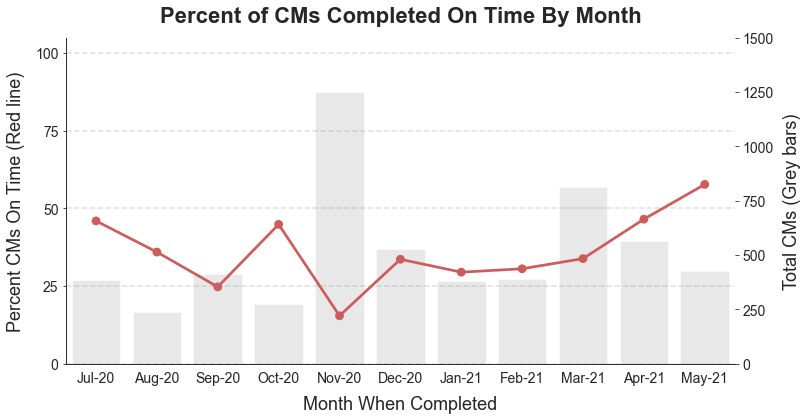

In [15]:
pointplot_with_barplot(
    cm_compliance,
    x=cm_compliance.year_month,
    point_y="percent_CMs_on_time",
    yaxis_freq_bar=250,
    yaxis_freq_point=25,
    bar_y="total_CMs",
    ymax_bar=1_500,
    xlabel="Month When Completed",
    ylabel_point="Percent CMs On Time (Red line)",
    ylabel_bar="Total CMs (Grey bars)",
    title="Percent of CMs Completed On Time By Month",
)

### PM:CM Ratio

In [16]:
CM_list = [
    "BOILER",
    "CHILLERS",
    "COOLING TOWERS",
    "HVAC",
    "HVAC INFRASTRUCTURE",
    "HVAC|REPAIR",
]

PM_list = [
    "PREVENTIVE_HVAC",
]

In [17]:
cond_cm = wr_main["problem_type"].isin(CM_list)
cond_pm = wr_main["primary_type"].isin(PM_list)

wr_HVAC = wr_main[cond_cm | cond_pm]
wr_HVAC["is_pm"] = wr_HVAC["primary_type"].isin(PM_list)

print(
    f"Filtering to HVAC request only takes us from {len(wr_fy):,} rows to {len(wr_HVAC):,} rows."
)

Filtering to HVAC request only takes us from 108,371 rows to 1,671 rows.


In [18]:
pm_cm_results = compute_pm_cm_by_month(wr_HVAC, end_date="2021-06-01")
pm_cm_results

,year_month,pm_cm_ratio,count_cm,count_pm,count_hvac
0,Jul-20,11.46,96,11,107
1,Aug-20,12.50,16,2,18
2,Sep-20,16.67,72,12,84
3,Oct-20,2.56,39,1,40
4,Nov-20,14.18,388,55,443
5,Dec-20,0.00,117,0,117
6,Jan-21,0.00,96,0,96
7,Feb-21,0.81,123,1,124
8,Mar-21,23.21,237,55,292
9,Apr-21,68.93,103,71,174


C:\Users\james.trimarco\OneDrive - City Of Baltimore\Documents\repos\KPI_central\utils\vis_utils.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(yticklabels)


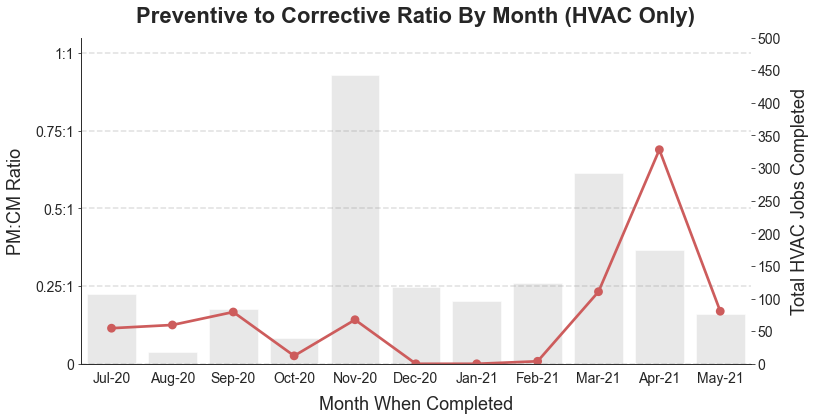

In [19]:
pointplot_with_barplot(
    pm_cm_results,
    x="year_month",
    point_y="pm_cm_ratio",
    bar_y="count_hvac",
    yaxis_freq_bar=50,
    yaxis_freq_point=25,
    ymax_point=105,
    ymax_bar=500,
    ylabel_point="PM:CM Ratio",
    ylabel_bar="Total HVAC Jobs Completed",
    xlabel="Month When Completed",
    title="Preventive to Corrective Ratio By Month (HVAC Only)",
    yticklabels=["0", "0", "0.25:1", "0.5:1", "0.75:1", "1:1"],
)

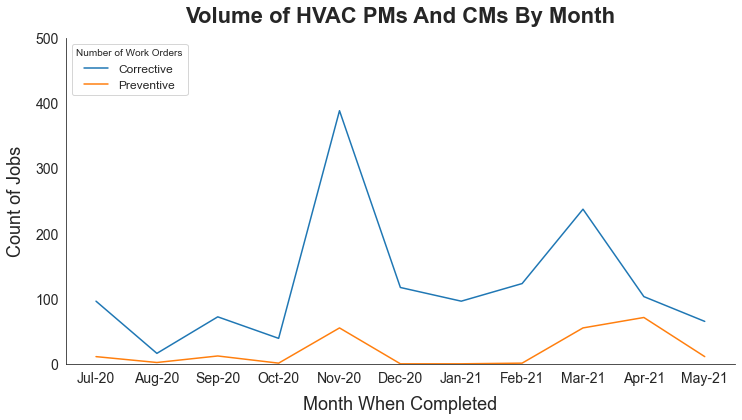

In [20]:
count_plot_data = pd.melt(
    pm_cm_results, id_vars=["year_month"], value_vars=["count_cm", "count_pm"]
)

ax = sns.lineplot(data=count_plot_data, y="value", x="year_month", hue="variable")
new_labels = ["Corrective", "Preventive"]
plt.legend(title="Number of Work Orders", loc="upper left", labels=new_labels)

ax.set(
    title="Volume of HVAC PMs And CMs By Month",
    xlabel="Month When Completed",
    ylabel="Count of Jobs",
    ylim=(0, 500),
)
sns.despine()

## Backlog analysis

### Backlog by primary type

In [21]:
wr_backlog = wr_fy.copy()

cond_backlog = ~wr_backlog["status"].isin(["Clo", "Can", "Rej", "R"])
wr_backlog = wr_backlog[cond_backlog]

print(len(wr_backlog))

7407


In [22]:
wr_backlog["primary_type"] = wr_backlog["primary_type"].replace(
    {
        "FIRE SUPPRESSION-PROTECTION": "FIRE SUPPRESSION",
        "PREVENTIVE_GENERAL": "PREVENTIVE_GEN",
    }
)

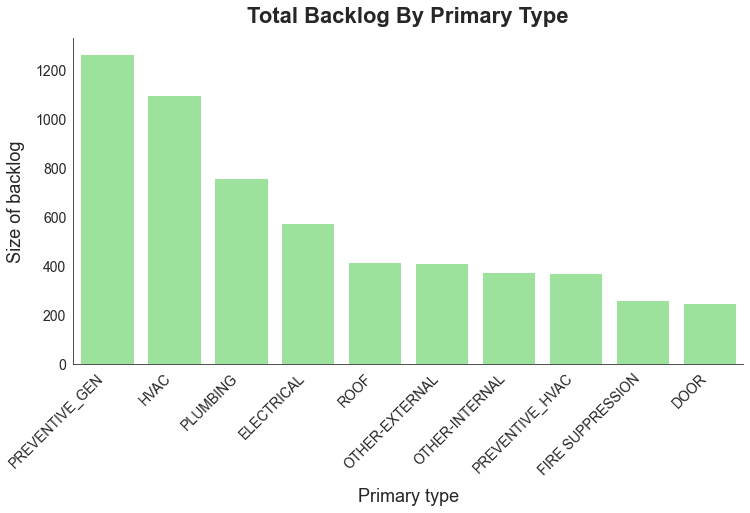

In [23]:
wr_backlog_by_primary = trim_small_groups(wr_backlog, "primary_type", n_mode=True, n=10)
ax = sns.countplot(
    data=wr_backlog_by_primary,
    x="primary_type",
    color="lightgreen",
    order=wr_backlog_by_primary["primary_type"].value_counts().index,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set(
    title="Total Backlog By Primary Type",
    ylabel="Size of backlog",
    xlabel="Primary type",
)
sns.despine()

### Backlog by status

<AxesSubplot:title={'center':'Backlog By Status of Work Request'}, ylabel='status'>

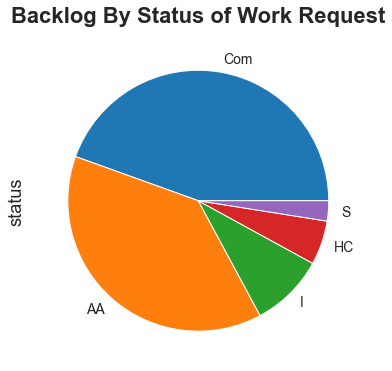

In [24]:
wr_backlog_by_status = trim_small_groups(wr_backlog, "status", n_mode=True, n=5)

wr_backlog_by_status.status.value_counts().plot.pie(
    title="Backlog By Status of Work Request"
)

In [ ]:
# ax = sns.countplot(
#     data=wr_backlog_by_status,
#     x="status",
#     color="lightgreen",
#     order=wr_backlog_by_status["status"].value_counts().index,
# )
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
# ax.set(title="Total Backlog By Status", ylabel="Size of backlog", xlabel="Primary type")
# sns.despine()